# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:
import json
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # sklearn 내 confusion matrix 계산 함수
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score


In [57]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [58]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic


# 0.97 submission 제출 파일을 가지고 test셋 분포 확인: train과 동일함

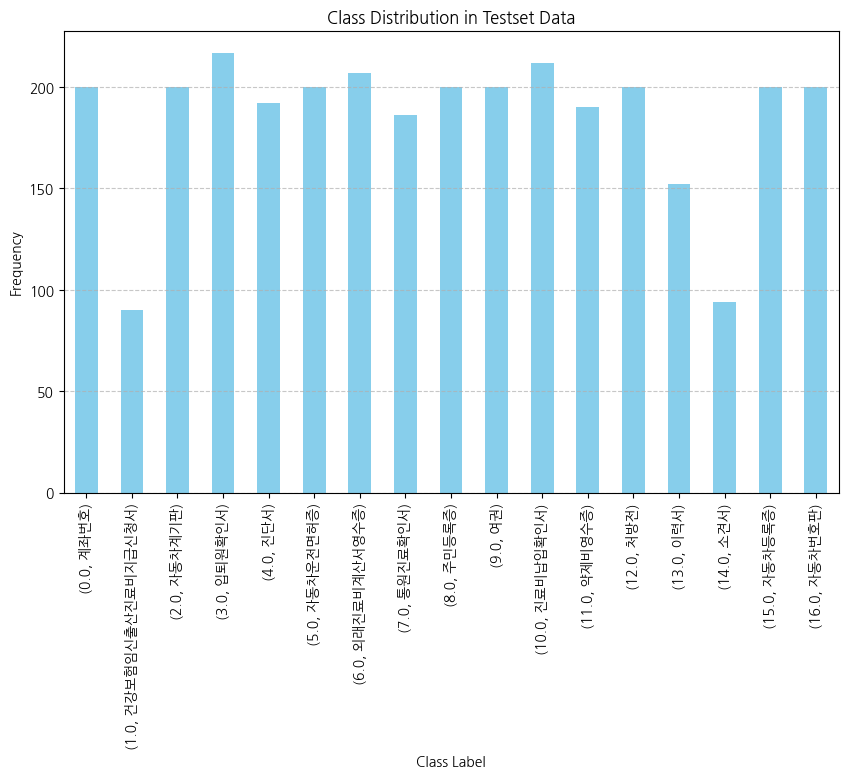

In [5]:
import pandas as pd

# CSV 파일 로드
meta = pd.read_csv(r'/data/ephemeral/home/datasets_fin/meta.csv')
data = pd.read_csv(r'/data/ephemeral/home/notebook/EASY_pred_ocr_0806_9514_34714.csv')
merged_data = pd.merge(data, meta, on='target', how='left')


# 'target' 컬럼의 값에 대한 빈도수 계산
class_counts = merged_data[['target','class_name_kr']].value_counts().sort_index()

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Testset Data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # 클래스 레이블이 수평으로 표시되도록 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 이미지 크기 확인

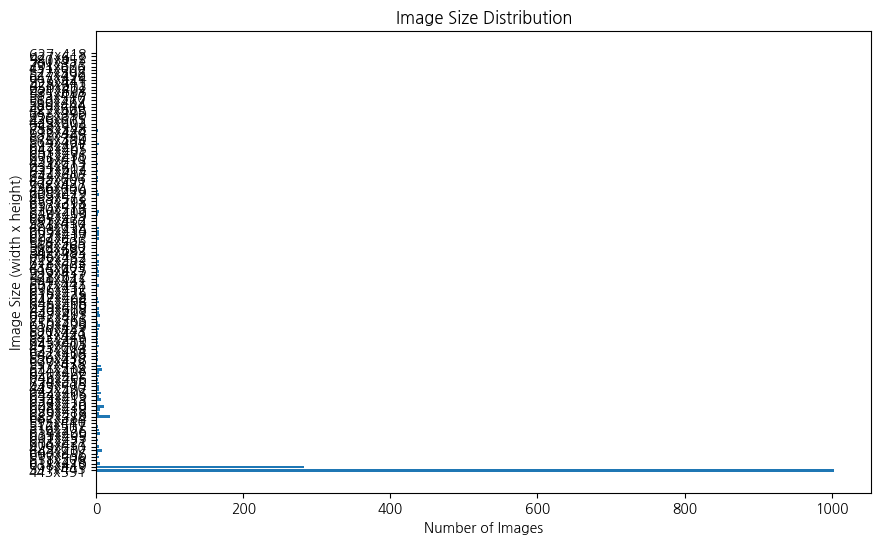

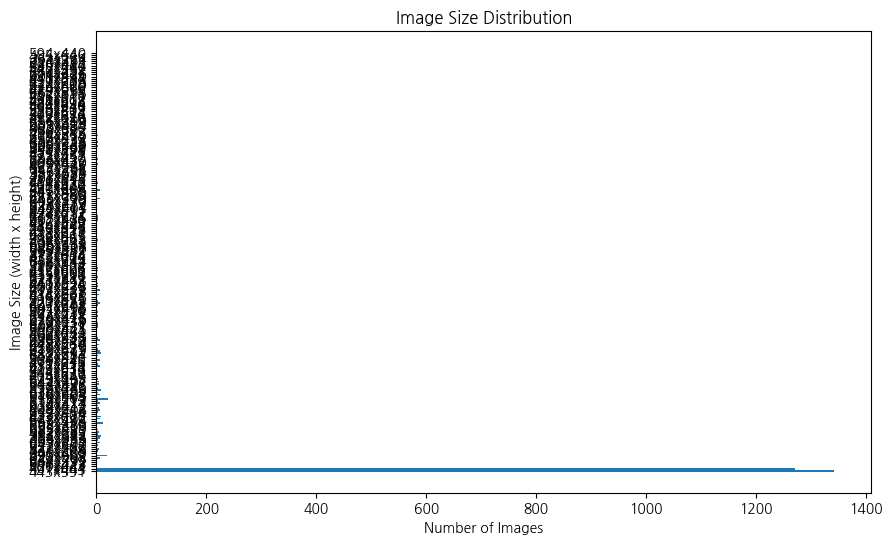

In [59]:
import matplotlib.pyplot as plt
from collections import Counter
import os
from PIL import Image

# 이미지 크기 추출 함수
def check_image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                sizes.append(img.size)
    return sizes

# 이미지 크기별 빈도 계산
directory = '/data/ephemeral/home/datasets_fin/combined_train/train'
sizes = check_image_sizes(directory)
size_counts = Counter(sizes)

# 크기와 빈도 데이터 분리
sizes, counts = zip(*size_counts.items())

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(counts)), counts, tick_label=[f'{w}x{h}' for w, h in sizes])
plt.xlabel('Number of Images')
plt.ylabel('Image Size (width x height)')
plt.title('Image Size Distribution')
plt.show()


directory2 = '/data/ephemeral/home/datasets_fin/test'
sizes2 = check_image_sizes(directory2)
size_counts2 = Counter(sizes2)

# 크기와 빈도 데이터 분리
sizes2, counts2 = zip(*size_counts2.items())

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(counts2)), counts2, tick_label=[f'{w}x{h}' for w, h in sizes2])
plt.xlabel('Number of Images')
plt.ylabel('Image Size (width x height)')
plt.title('Image Size Distribution')
plt.show()


## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [60]:
wandb.init(project = 'helloyoonjae-', name = 'fastcampus_cv11')

In [73]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# data config
data_path = '/data/ephemeral/home/datasets_fin/combined_train/train'

# model config
model_name = 'efficientnet_b4'#'tiny_vit_21m_384.dist_in22k_ft_in1k'#'efficientnetv2_rw_m.agc_in1k' #'vit_base_patch16_224.augreg_in1k' #'efficientnet_b3.ra2_in1k'#'densenet121.ra_in1k'# #'resnet101' #'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
pre_img_size = 380
img_size = 380 #224 #256
LR = 5e-4
EPOCHS = 5
BATCH_SIZE = 4
num_workers = 0
early_stopping_patience = 5  # Early Stopping 설정
augment_ratio = 200

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [74]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [75]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, oversample=False, augment_ratio=1):
        self.df = pd.read_csv(csv)
        self.path = path
        self.transform = transform
        self.oversample = oversample
        self.augment_ratio = augment_ratio

        # 클래스간 불균형 해소를 위한 샘플 증식
        if self.oversample:
            # 각 클래스별로 데이터 수 계산
            class_counts = np.bincount(self.df.values[:, 1].astype(int))

            # 각 클래스별로 증식할 횟수 설정 (이 예제에서는 최대 데이터 수에 맞춤)
            max_class_count = max(class_counts)
            oversample_factors = [max_class_count // count for count in class_counts]
            # Class 3, 7 가중치 2로 변경
            # oversample_factors[3] = 2
            # oversample_factors[7] = 2 
            # oversample_factors[14] = 3 

            # 각 클래스별로 데이터를 증식한 새로운 데이터 프레임 생성
            oversampled_data = [self.df.values[self.df.values[:, 1] == cls].repeat(factor, axis=0) for cls, factor in enumerate(oversample_factors)]
            oversampled_data = np.vstack(oversampled_data)

            self.df = pd.DataFrame(oversampled_data, columns=self.df.columns)

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df.iloc[real_idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert("RGB"))
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    
    
# meta.csv 파일 읽기
meta_data = pd.read_csv('/data/ephemeral/home/datasets_fin/meta.csv')
label_to_class_name = dict(zip(meta_data['target'], meta_data['class_name']))

# 전처리

In [9]:
import numpy as np
from PIL import Image
import albumentations as A

class Crop(A.ImageOnlyTransform):
    def __init__(self, crop_position='top', always_apply=False, p=1.0):
        super(Crop, self).__init__(always_apply, p)
        self.crop_position = crop_position

    def apply(self, img, **params):
        # 이미지를 PIL 이미지로 변환 (Albumentations은 NumPy 배열을 사용)
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        width, height = img.size

        if self.crop_position == 'top':
            img = img.crop((0, 0, width, height // 2))
        elif self.crop_position == 'bottom':
            img = img.crop((0, height // 2, width, height))
        else:
            raise ValueError("crop_position must be 'top' or 'bottom'")

        # PIL 이미지를 다시 NumPy 배열로 변환
        img = np.array(img)
        return img


In [10]:
class Adjust(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(Adjust, self).__init__(always_apply, p)

    def apply(self, img, **params):
        
        # 이미지를 PIL 이미지로 변환 (Albumentations은 NumPy 배열을 사용)
        if isinstance(img, np.ndarray):
            # img = Image.fromarray(img)
            img = Image.fromarray(img.astype(np.uint8))
        # PIL 이미지를 다시 NumPy 배열로 변환
        img = np.array(img)               
                
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        average_brightness = np.mean(gray_image)
        # print(average_brightness)
        if average_brightness < 160:
            img_pil = Image.fromarray(img)
            # Adjust brightness
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(1.5)
            
            # Adjust contrast
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(2.0)
            
            img = np.array(img_pil)
        
        return img

# 정규화 수치를 기존것을 대체하여 train데이터에 대해 설정하기: 효과가 없어서 안하는 것으로 함

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Albumentations transform 정의
pre_img_size = pre_img_size  # 사전 정의된 이미지 크기 (필요에 따라 수정)
img_size = pre_img_size
augment_ratio = augment_ratio

transform = A.Compose([
    A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    A.Resize(height=img_size, width=img_size),
    
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        A.GaussianBlur(blur_limit=(1, 7), p=0.5)
    ], p=0.75),
    # A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.75),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    # RotateBy30(p=0.75),
    A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=0.5),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.1),
    # A.Rotate(limit=30, p=0.75),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.OpticalDistortion(p=0.5),
    A.Transpose(p=0.5),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

class CustomDataset(ImageFolder):
    def __init__(self, root, transform=None, augment_ratio=1):
        super().__init__(root, transform=None)
        self.custom_transform = transform
        self.augment_ratio = augment_ratio

    def __getitem__(self, index):
        path, target = self.samples[index % len(self.samples)]
        sample = self.loader(path).convert("RGB")  # PIL 이미지로 변환
        if self.custom_transform is not None:
            sample = np.array(sample)  # Albumentations는 NumPy 배열을 사용
            sample = self.custom_transform(image=sample)["image"]  # 변환 적용
        return sample, target
    
    def __len__(self):
        return len(self.samples) * self.augment_ratio

# 데이터셋 루트 경로 설정 (필요에 따라 수정)
dataset_root = '/data/ephemeral/home/datasets_fin/combined_train/'

# 데이터셋 로드
dataset = CustomDataset(root=dataset_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 채널별 평균과 표준 편차 계산
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in tqdm(dataloader, desc="Calculating mean and std", unit="batch"):
    data = data.float()/ 255.0  # float 타입으로 변환하고 0-1 범위로 스케일링
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# 계산된 값을 사용하여 정규화
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# 정규화된 데이터셋 로드
custom_dataset = CustomDataset(root=dataset_root, transform=custom_transform)


In [76]:
# https://demo.albumentations.ai/
import albumentations as A
from albumentations.pytorch import ToTensorV2

# horizontal_flip, vertical_flip, double_flip, transpose 등 변환 정의
horizontal_flip = A.HorizontalFlip(p=1)
vertical_flip = A.VerticalFlip(p=1)
double_flip = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
])
transpose = A.Transpose(p=1)
transpose_hflip = A.Compose([
    A.Transpose(p=1), 
    A.HorizontalFlip(p=1),
])
transpose_vflip = A.Compose([
    A.Transpose(p=1),
    A.VerticalFlip(p=1),
])
transpose_dflip = A.Compose([
    A.Transpose(p=1),  
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
])

# Augmentation을 위한 transform 코드
trn_transform = A.Compose([
    
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=1),
        A.GaussianBlur(blur_limit=(1, 7), p=1),
        A.MotionBlur(blur_limit=(3, 7), p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=1),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.Rotate(limit=(0, 360), p=0.75),
    A.GridDistortion(always_apply=False, p=0.75, num_steps=6, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, normalized=False),
    A.OneOf([
        horizontal_flip,
        vertical_flip,
        double_flip,
        transpose,
        transpose_hflip,
        transpose_vflip,
        transpose_dflip
    ], p=1.0),
    A.OneOf([
        A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=(-0.3, 0.3), shift_limit=(-0.05, 0.09), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.93, 2.22), per_channel=True, elementwise=True),
        A.ISONoise(always_apply=False, p=1.0, intensity=(0.38, 1.0), color_shift=(0.18, 0.47)),
        A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(0.19, 0.62), contrast_limit=(-0.02, 0.62), brightness_by_max=True)
    ], p=0.75),
    # A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    # A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    A.Resize(height=380, width=380),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    Adjust(always_apply=True),
    # A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    # A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    A.Resize(height=380, width=380),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [77]:
# 데이터셋 및 데이터 로더 정의
trn_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/train_labelupdate.csv",
    "/data/ephemeral/home/datasets_fin/combined_train/train",
    transform=trn_transform,
    oversample=True,
    augment_ratio=augment_ratio
)


tst_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/sample_submission.csv",
    "/data/ephemeral/home/datasets_fin/test/",
    transform=tst_transform,
    oversample=False,
    augment_ratio=1
)


ori_traindata_num = int(len(trn_dataset)/augment_ratio)
print(f"Original training data count: {ori_traindata_num}")
print(f"Augmented training data count: {len(trn_dataset)}")
print(f"Test data count: {len(tst_dataset)}")
# wandb config 업데이트
wandb.config.update({
    "Trn_data": len(trn_dataset)
})

Original training data count: 1666
Augmented training data count: 333200
Test data count: 3140


# 기본 valid

In [206]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리
import copy
# validation config
VALID_RATIO = 0.8

total_size = len(trn_dataset)
train_num, valid_num = int(total_size * VALID_RATIO), total_size - int(total_size * VALID_RATIO)

# train - valid set 나누기
generator = torch.Generator().manual_seed(SEED)
train_dataset, valid_dataset = torch.utils.data.random_split(trn_dataset, [train_num, valid_num], generator = generator)

valid_data = copy.deepcopy(valid_dataset)
valid_data.dataset.transform = tst_transform

print(f'Train dataset 개수: {len(train_dataset)}')
print(f'Validation dataset 개수: {len(valid_dataset)}')
print(f'Test dataset 개수: {len(tst_dataset)}')

Train dataset 개수: 266560
Validation dataset 개수: 66640
Test dataset 개수: 3140


# stratified valid

In [78]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import numpy as np
import copy

VALID_RATIO = 0.8

# 원본 CSV 파일 읽기
original_df = pd.read_csv("/data/ephemeral/home/datasets_fin/train_labelupdate.csv")

# 원본 데이터의 라벨 추출
labels = original_df['target'].values

# StratifiedShuffleSplit 사용하여 원본 데이터셋을 학습 및 검증으로 분할
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-VALID_RATIO, random_state=SEED)
train_index, valid_index = next(sss.split(np.zeros(len(labels)), labels))

# 학습 및 검증 데이터셋을 원본 데이터프레임에서 분리
train_df = original_df.iloc[train_index]
valid_df = original_df.iloc[valid_index]

# 증강된 데이터셋을 원래 데이터셋에 대한 인덱스를 기반으로 분리
# train_df와 valid_df의 인덱스를 기반으로 증강된 데이터셋에 적용
train_indices = np.hstack([np.arange(i * augment_ratio, (i + 1) * augment_ratio) for i in train_index])
valid_indices = np.hstack([np.arange(i * augment_ratio, (i + 1) * augment_ratio) for i in valid_index])

train_dataset = torch.utils.data.Subset(trn_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(trn_dataset, valid_indices)

# 검증 데이터에 tst_transform 적용
valid_data = copy.deepcopy(valid_dataset)
valid_data.dataset.transform = tst_transform

print(f'Train dataset 개수: {len(train_dataset)}')
print(f'Validation dataset 개수: {len(valid_dataset)}')
print(f'Test dataset 개수: {len(tst_dataset)}')


Train dataset 개수: 251200
Validation dataset 개수: 62800
Test dataset 개수: 3140


In [79]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers=0,
    pin_memory=True
    )


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# timm 모델

In [ ]:
torch.cuda.empty_cache()

# 모델을 불러옵니다.
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17,
    drop_rate=0.2
).to(device)

# 손실 함수를 정의합니다.
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저를 정의합니다.
optimizer = AdamW(model.parameters(), lr=LR)

# Learning Rate Scheduler를 정의합니다.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping을 위한 변수 초기화
best_loss = float('inf')
early_stopping_counter = 0

In [36]:
# 한 에폭(epoch) 동안 모델을 학습시키는 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device, log_interval=1000):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for batch_idx, (image, targets) in enumerate(pbar):
        if image is None or targets is None:
            continue
        
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        # 지정된 간격으로만 wandb에 로그를 남김
        if batch_idx % log_interval == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "cumulative_loss": train_loss / (batch_idx + 1)
            })

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    # 에폭 단위로 wandb에 학습 과정 로그
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "train_f1": train_f1})

    return ret

In [44]:
torch.cuda.empty_cache()


# 학습 과정을 저장할 리스트 초기화
train_losses = []
train_accuracies = []
train_f1_scores = []

# 모델 학습 루프
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
    ret['epoch'] = epoch

    train_losses.append(ret["train_loss"])
    train_accuracies.append(ret["train_acc"])
    train_f1_scores.append(ret["train_f1"])

    log = ""
    for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    scheduler.step(ret["train_loss"])

    if ret["train_loss"] < best_loss:
        best_loss = ret["train_loss"]
        early_stopping_counter = 0
        torch.save(model.state_dict(), f"{model_name}_{img_size}SIZE_{BATCH_SIZE}BATCH_{EPOCHS}EPOCH_best_model.pth")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# wandb 실행 종료
wandb.finish()

NameError: name 'model' is not defined

# custom attention 모델

In [80]:
# 기본코드
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, in_features, out_features):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights
    

class CustomEfficientNetB4(nn.Module):
    def __init__(self, num_classes, attention_size=1792):
        super(CustomEfficientNetB4, self).__init__()
        self.base_model = timm.create_model('efficientnet_b4', pretrained=True)
        
        # Remove the existing classifier
        self.base_model.reset_classifier(0, '')

        # Add SE attention mechanism
        self.attention = AttentionModule(attention_size, attention_size)

        # Add dropout layer with 0.2 ratio
        self.dropout = nn.Dropout(p=0.2)
        # drop_out 비율 20%

        # New classifier with attention
        self.classifier = nn.Linear(attention_size, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        
        # Global average pooling
        x = x.mean([2, 3])

        # Apply attention mechanism
        x = self.attention(x)

        # Apply dropout with 0.2 ratio
        x = self.dropout(x)

        # Final classification
        x = self.classifier(x)

        return x


In [81]:
# 개선한 코드
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, in_features, out_features):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, out_features),
            # nn.Sigmoid()
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights
    

class CustomEfficientNetB4(nn.Module):
    def __init__(self, num_classes, attention_size=1792):
        super(CustomEfficientNetB4, self).__init__()
        self.base_model = timm.create_model('efficientnet_b4', pretrained=True)
        
        # Remove the existing classifier
        self.base_model.reset_classifier(0, '')

        # Add SE attention mechanism
        self.attention = AttentionModule(attention_size, attention_size)

        # Add dropout layer with 0.2 ratio
        self.dropout = nn.Dropout(p=0.2)
        
        # Batch normalization after dropout
        self.batch_norm = nn.BatchNorm1d(attention_size)

        # New classifier with attention
        self.classifier = nn.Linear(attention_size, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Adaptive pooling

        # Apply attention mechanism
        attention_output = self.attention(x)
        
        # Residual Connection
        x = x + attention_output

        # Apply dropout with 0.2 ratio
        x = self.dropout(x)

        # Apply BatchNorm
        x = self.batch_norm(x)

        # Final classification
        x = self.classifier(x)

        return x


In [82]:
# one epoch 학습을 위한 함수
def training(model, dataloader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(dataloader)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item()}")
        
    train_loss /= len(dataloader)
    train_acc = accuracy_score(targets_list, preds_list)    
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    return model, train_loss, train_acc, train_f1

def evaluation(model, dataloader, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)

            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Valid Loss: {loss.item()}")

    valid_loss = valid_loss / len(dataloader)
    valid_acc = accuracy_score(targets_list, preds_list)  
    valid_f1 = f1_score(targets_list, preds_list, average='macro')

    return valid_loss, valid_acc, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, early_stopping_patience, model_name, run):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1
    best_model = None

    for epoch in range(num_epochs):
        model, train_loss, train_acc, train_f1 = training(model, train_dataloader, criterion, optimizer, device, epoch, num_epochs)
        valid_loss, valid_acc, valid_f1 = evaluation(model, valid_dataloader, criterion, device, epoch, num_epochs)

        monitoring_value = {'train_loss': train_loss, 'train_accuracy': train_acc, 'train_f1': train_f1, 
                            'valid_loss': valid_loss, 'valid_accuracy': valid_acc, 'valid_f1': valid_f1}
        
        run.log(monitoring_value, step=epoch)
        
        print(f'''Epoch [{epoch + 1}/{num_epochs}] Finished
        Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train F1: {train_f1}
        Valid Loss: {valid_loss}, Valid Accuracy: {valid_acc}, Valid F1: {valid_f1}''')

        if valid_acc > valid_max_accuracy:
          valid_max_accuracy = valid_acc

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0
            print('Model Saved')

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping")
            break

    return best_model, valid_max_accuracy

In [83]:
# 모델 생성
torch.cuda.empty_cache()

num_classes = 17

model = CustomEfficientNetB4(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [215]:
# wandb에 모델의 weight & bias, graident 시각화
run = wandb.init(project = 'helloyoonjae-', name = 'fastcampus_cv11')
run.watch(model, loss_fn, log = 'all', log_graph = True)

model, valid_max_accuracy = training_loop(model, trn_loader, valid_loader, loss_fn, optimizer, device, EPOCHS, early_stopping_patience, model_name, run)
print(f'Valid Max Accuracy: {valid_max_accuracy}')

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Epoch [1/5] - Valid Loss: 0.0011790299322456121: 100%|██████████| 2083/2083 [27:23<00:00,  1.27it/s] 


Epoch [1/5] Finished
        Train Loss: 0.08210471120887156, Train Accuracy: 0.9717436974789916, Train F1: 0.9718605596122074
        Valid Loss: 0.02426432988108456, Valid Accuracy: 0.9915216086434574, Valid F1: 0.991518361126919
Model Saved


Epoch [2/5] - Valid Loss: 5.282363417791203e-06: 100%|██████████| 2083/2083 [27:15<00:00,  1.27it/s] 


Epoch [2/5] Finished
        Train Loss: 0.029778405871515132, Train Accuracy: 0.9903481392557023, Train F1: 0.9903592395788662
        Valid Loss: 0.01894671269403257, Valid Accuracy: 0.9934873949579832, Valid F1: 0.9935040025406875
Model Saved


Epoch [3/5] - Valid Loss: 0.010572182945907116: 100%|██████████| 2083/2083 [29:24<00:00,  1.18it/s]  


Epoch [3/5] Finished
        Train Loss: 0.021227325625316335, Train Accuracy: 0.9932623049219688, Train F1: 0.9932538465641934
        Valid Loss: 0.02015908563472813, Valid Accuracy: 0.9933973589435774, Valid F1: 0.9933807860244277


Epoch [4/5] - Train Loss: 0.013959826901555061:  22%|██▏       | 2342/10413 [14:17<49:39,  2.71it/s]    

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

# TTA (Test-Time Augmentation) 

In [177]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image, ImageEnhance
import pandas as pd
import os
import cv2

# Albumentations transform 정의
pre_img_size = 380  # 사전 정의된 이미지 크기 (필요에 따라 수정)

transform = A.Compose([
    A.LongestMaxSize(max_size=pre_img_size, always_apply=True),
    A.PadIfNeeded(min_height=pre_img_size, min_width=pre_img_size, border_mode=0, value=(255, 255, 255)),
    ToTensorV2(),
])

class Adjust(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(Adjust, self).__init__(always_apply, p)

    def apply(self, img, **params):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8))
        img = np.array(img)
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        average_brightness = np.mean(gray_image)
        if average_brightness < 160:
            img_pil = Image.fromarray(img)
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(1.5)
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(2.0)
            img = np.array(img_pil)
        return img

class ImageDataset2(Dataset):
    def __init__(self, csv_file, path, transform=None):
        self.df = pd.read_csv(csv_file)
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df.iloc[real_idx]
        img_path = os.path.join(self.path, name)
        
        try:
            img = np.array(Image.open(img_path).convert("RGB"))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = np.zeros((pre_img_size, pre_img_size, 3), dtype=np.uint8)  # 빈 이미지로 대체
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

# TTA 변환 정의
tta_transforms = [
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.Transpose(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        A.Transpose(p=1.0),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.Transpose(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        # A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        # A.GaussianBlur(blur_limit=(1, 7), p=0.5),
        A.Transpose(p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    # A.Compose([
    #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #     ToTensorV2()
    # ])  # 원본 이미지
]

tta_dataset = ImageDataset2(
    "/data/ephemeral/home/datasets_fin/sample_submission.csv",
    "/data/ephemeral/home/datasets_fin/test/",
    transform=transform
)

tta_loader = DataLoader(
    tta_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# TTA inference function
def tta_inference(loader, model, device, tta_transforms):
    model.eval()
    all_outputs = []
    
    for images, _ in tqdm(loader):
        images = images.to(device).float()  # 이미지 텐서를 float 형식으로 변환
        batch_outputs = torch.zeros(images.size(0), 17).to(device)  # 17은 클래스 수
        
        for tta_transform in tta_transforms:
            tta_images = []
            for image in images:
                tta_image = tta_transform(image=image.permute(1, 2, 0).cpu().numpy().astype(np.float32))['image']
                tta_images.append(tta_image.to(device).float())
            tta_images = torch.stack(tta_images)
            with torch.no_grad():
                preds = model(tta_images)
                batch_outputs += preds
        
        # TTA 평균 내기 (Soft Voting)
        batch_outputs /= len(tta_transforms)
        
        # 최종 예측 값을 리스트에 저장
        all_outputs.append(batch_outputs.cpu().numpy())
    
    # 모든 배치의 예측 값을 연결
    all_outputs = np.concatenate(all_outputs, axis=0)
    return all_outputs

# TTA를 적용한 예측
all_outputs = tta_inference(tta_loader, model, device, tta_transforms)
preds_list = np.argmax(all_outputs, axis=1)

# 예측 결과를 데이터프레임으로 저장
pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

# 제출 형식 파일을 읽어와 ID 열이 일치하는지 확인
sample_submission_df = pd.read_csv("/data/ephemeral/home/datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

# 예측 결과를 CSV 파일로 저장
pred_df.to_csv(f"{model_name}_{pre_img_size}SIZE_{BATCH_SIZE}BATCH_{EPOCHS}EPOCH_0809_TTA_pred2.csv", index=False)
print(pred_df.head())


  0%|          | 0/393 [00:00<?, ?it/s]

100%|██████████| 393/393 [02:51<00:00,  2.30it/s]

                     ID  target
0  0008fdb22ddce0ce.jpg       2
1  00091bffdffd83de.jpg      12
2  00396fbc1f6cc21d.jpg       5
3  00471f8038d9c4b6.jpg      12
4  00901f504008d884.jpg       2


In [170]:
# 테스트 데이터에 대한 예측 수행
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)
    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

# 예측 결과를 데이터프레임으로 저장
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

# 제출 형식 파일을 읽어와 ID 열이 일치하는지 확인
sample_submission_df = pd.read_csv("/data/ephemeral/home/datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

# 예측 결과를 CSV 파일로 저장
pred_df.to_csv(f"{model_name}_{img_size}SIZE_{BATCH_SIZE}BATCH_{EPOCHS}EPOCH_0809_pred.csv", index=False)
print(pred_df.head())

100%|██████████| 393/393 [01:16<00:00,  5.16it/s]

                     ID  target
0  0008fdb22ddce0ce.jpg       2
1  00091bffdffd83de.jpg      12
2  00396fbc1f6cc21d.jpg       5
3  00471f8038d9c4b6.jpg      12
4  00901f504008d884.jpg       2


# 97 정답지와 비교

Macro F1 Score: 0.9305574604518821


/tmp/ipykernel_1149539/3890291298.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, fontsize=10) # fontproperties=font_prop,


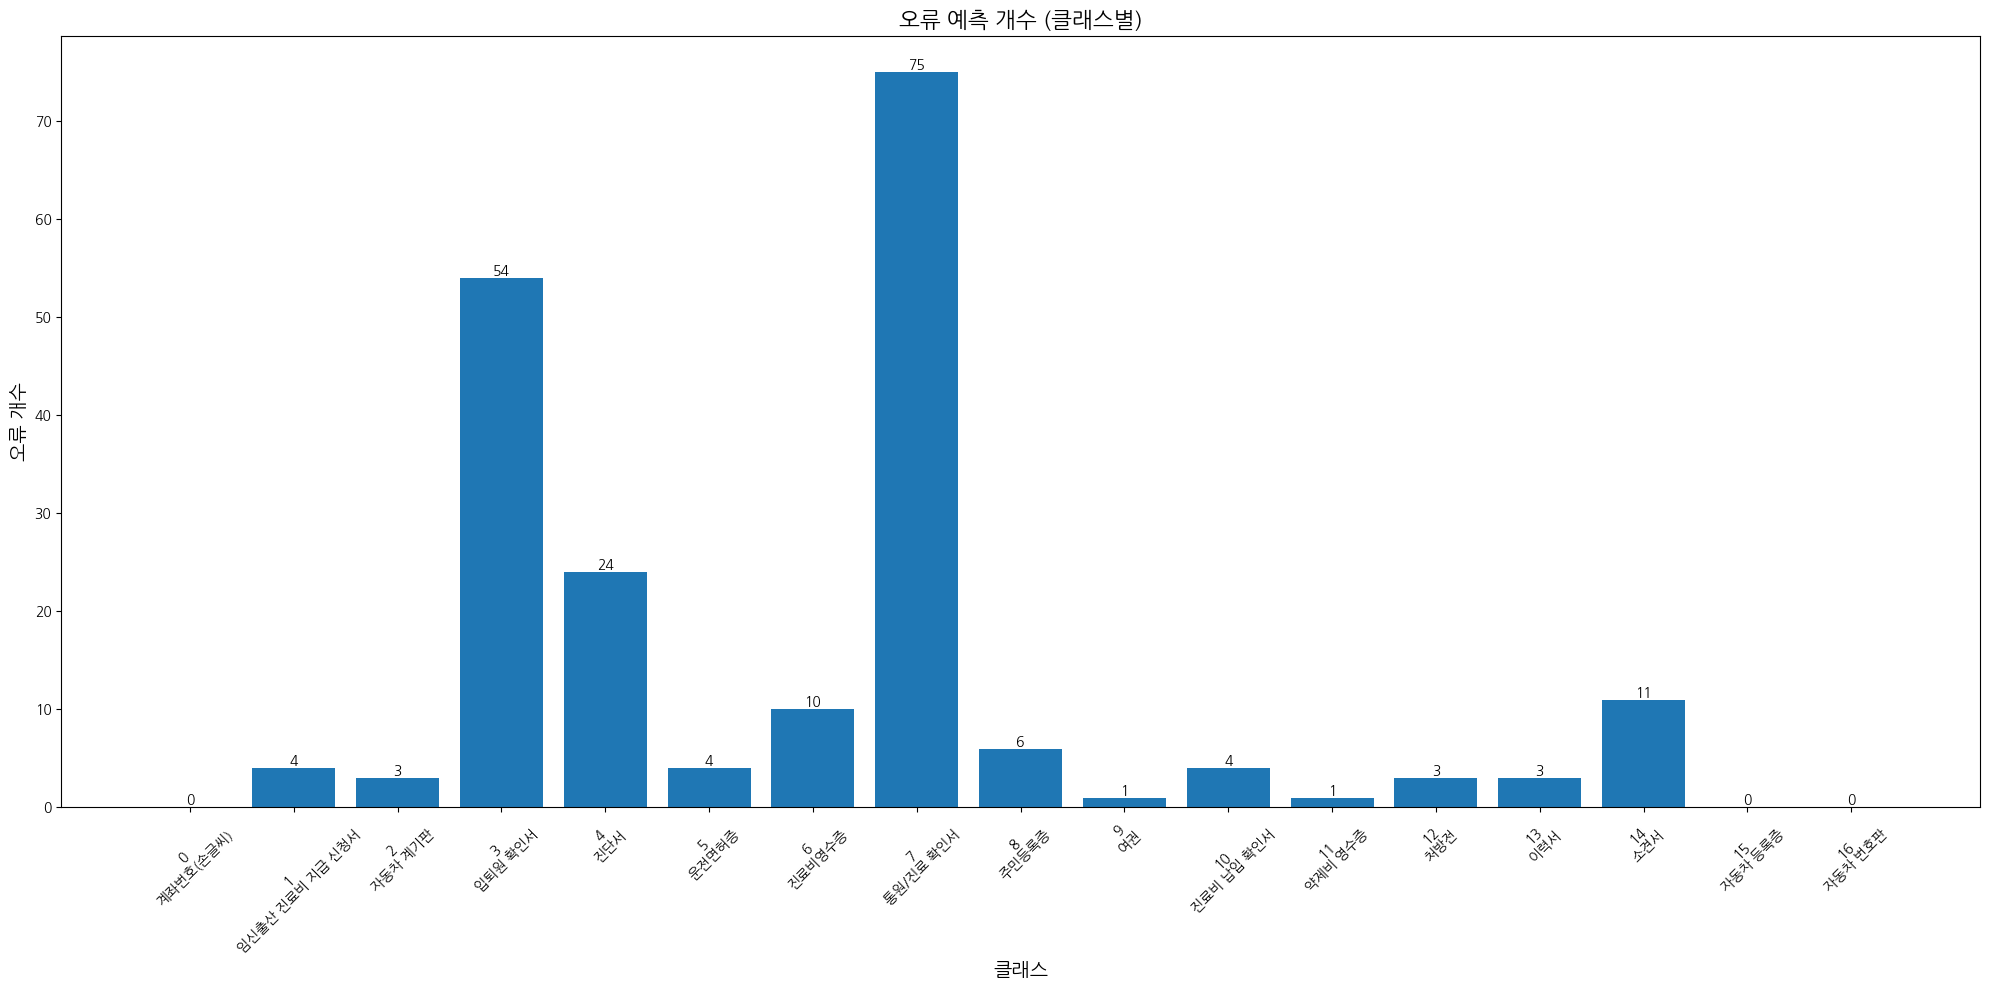

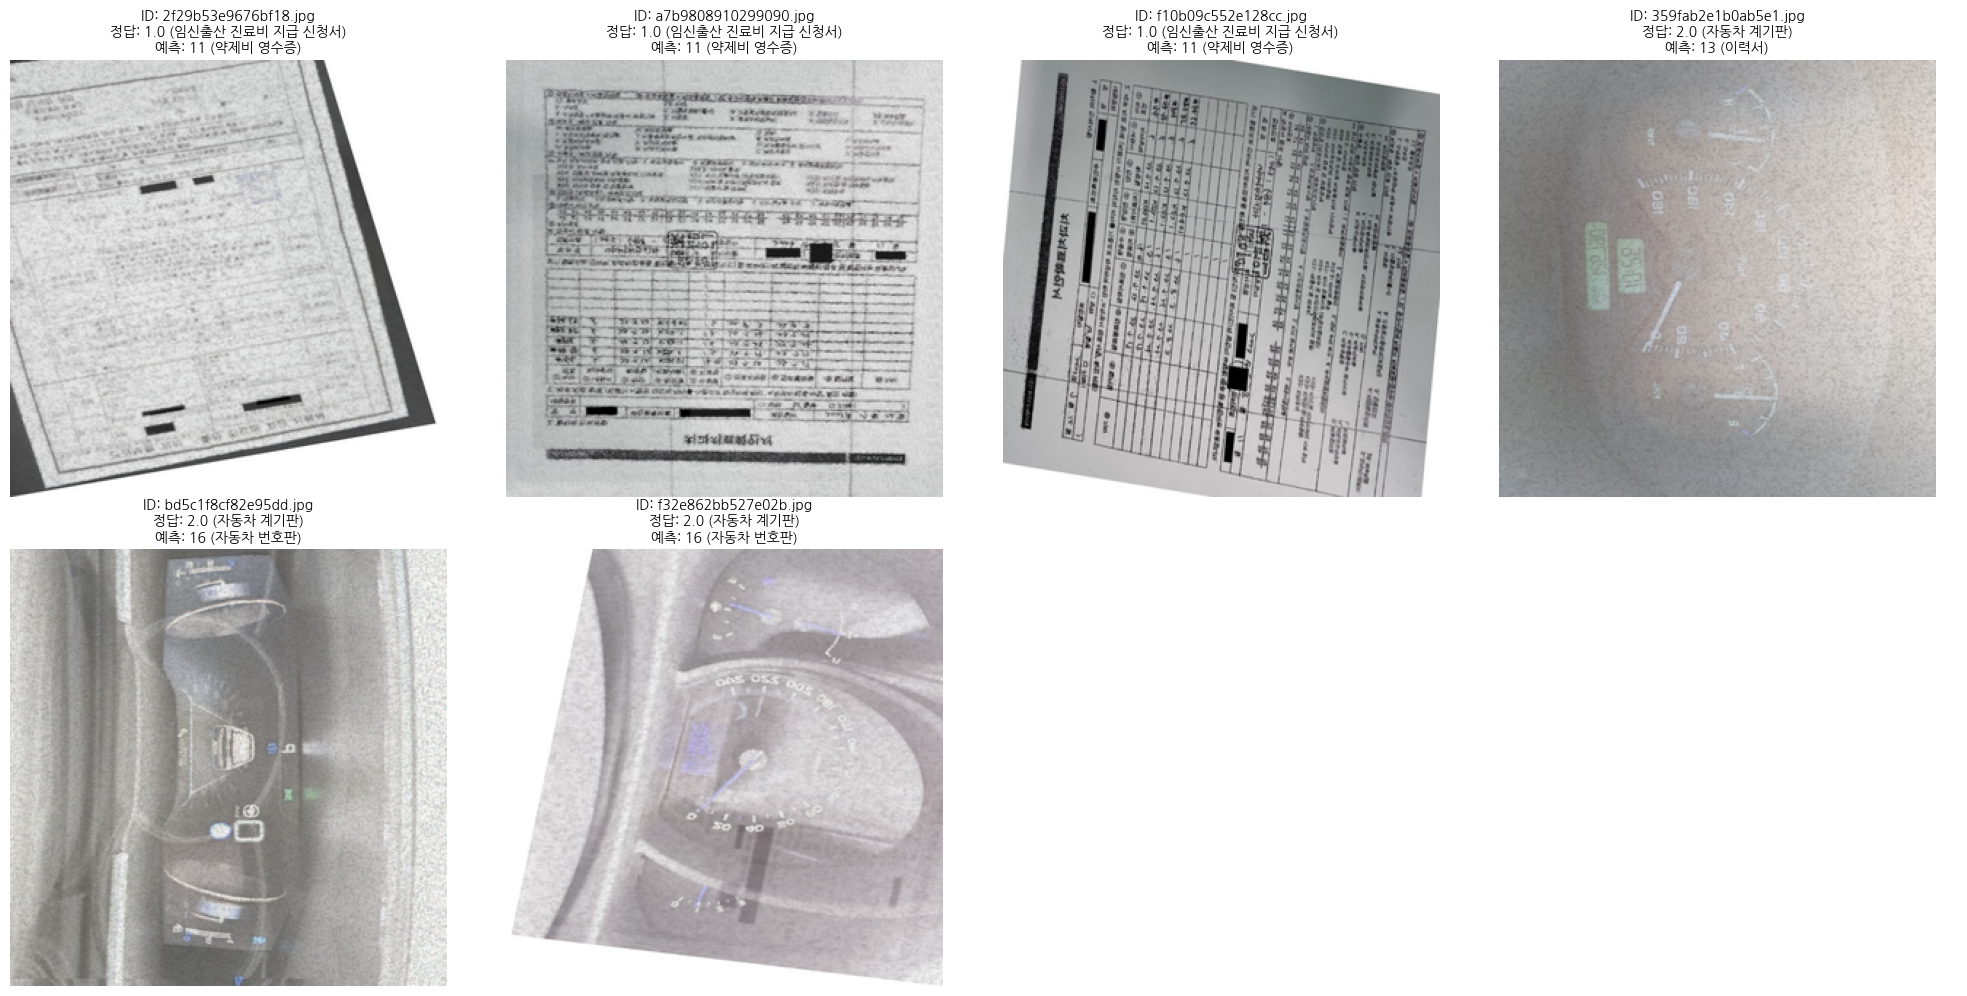

총 6개의 이미지가 표시되었습니다.


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import f1_score
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties


def load_predictions(file_paths):
    """여러 모델의 예측 결과를 로드합니다."""
    predictions = {}
    for path in file_paths:
        model_name = os.path.basename(path).split('.')[0]
        df = pd.read_csv(path)
        # ID 컬럼 중복 제거 및 예측 컬럼 이름 변경
        df = df[['ID', 'target']].rename(columns={'target': model_name})
        predictions[model_name] = df
    return predictions

def find_different_predictions(predictions):
    """모든 모델에서 다르게 예측한 항목을 찾습니다."""
    # 모든 예측을 하나의 DataFrame으로 병합
    all_predictions = predictions[list(predictions.keys())[0]]
    for model, df in list(predictions.items())[1:]:
        all_predictions = pd.merge(all_predictions, df, on='ID', suffixes=('', f'_{model}'))
    
    # 예측 컬럼만 선택
    prediction_columns = [col for col in all_predictions.columns if col != 'ID']
    
    # 예측이 다른 행만 선택
    different_predictions = all_predictions[all_predictions[prediction_columns].nunique(axis=1) > 1]
    return different_predictions

def calculate_macro_f1(ground_truth, predictions):
    """Macro F1 점수를 계산합니다."""
    return f1_score(ground_truth, predictions, average='macro')

def plot_error_distribution(ground_truth, predictions):
    """각 클래스별 오류 예측 개수를 bar plot으로 표시합니다."""
    # 클래스 이름 정의
    class_names = {
        0: "계좌번호(손글씨)", 1: "임신출산 진료비 지급 신청서", 2: "자동차 계기판", 3: "입퇴원 확인서", 4: "진단서", 
        5: "운전면허증", 6: "진료비영수증", 7: "통원/진료 확인서", 8: "주민등록증", 9: "여권", 
        10: "진료비 납입 확인서", 11: "약제비 영수증", 12: "처방전", 13: "이력서", 14: "소견서", 
        15: "자동차 등록증", 16: "자동차 번호판"
    }

    error_counts = {i: 0 for i in range(len(class_names))}  # 모든 클래스에 대해 초기화
    for gt, pred in zip(ground_truth, predictions):
        if gt != pred:
            error_counts[gt] += 1
    
    classes = sorted(error_counts.keys())
    counts = [error_counts[c] for c in classes]
    class_labels = [f"{c}\n{class_names[c]}" for c in classes]
    
    # 나눔 폰트 설정
    # font_path = './font/NanumGothic.otf'
    # font_prop = FontProperties(fname=font_path)
    
    plt.figure(figsize=(20, 10))
    bars = plt.bar(class_labels, counts)
    plt.title("오류 예측 개수 (클래스별)", fontsize=16)# fontproperties=font_prop, 
    plt.xlabel("클래스", fontsize=14)# fontproperties=font_prop, 
    plt.ylabel("오류 개수", fontsize=14)# fontproperties=font_prop, 
    plt.xticks(rotation=45, ha='center')
    
    # x축 레이블에 폰트 적용
    ax = plt.gca()
    ax.set_xticklabels(class_labels, fontsize=10) # fontproperties=font_prop, 
    
    plt.tight_layout()
    
    # 각 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')# fontproperties=font_prop, 
    
    plt.show()  
    
    
def display_images_and_predictions(different_predictions, image_dir, ground_truth_name, prediction_name, class_filter=None, max_images_per_class=3):
    """다르게 예측된 항목의 이미지와 예측 결과를 표시합니다."""
    # 나눔 폰트 설정
    # font_path = './font/NanumGothic.otf'
    # font_prop = FontProperties(fname=font_path)
    class_names = {
        0: "계좌번호(손글씨)", 1: "임신출산 진료비 지급 신청서", 2: "자동차 계기판", 3: "입퇴원 확인서", 4: "진단서", 
        5: "운전면허증", 6: "진료비영수증", 7: "통원/진료 확인서", 8: "주민등록증", 9: "여권", 
        10: "진료비 납입 확인서", 11: "약제비 영수증", 12: "처방전", 13: "이력서", 14: "소견서", 
        15: "자동차 등록증", 16: "자동차 번호판"
    }
    
    # 클래스별로 이미지 분류
    class_images = {c: [] for c in range(len(class_names))}
    for idx, row in different_predictions.iterrows():
        ground_truth = row[ground_truth_name]
        if class_filter is None or ground_truth in class_filter:
            class_images[ground_truth].append(row)
    
    # 표시할 이미지 선택
    images_to_display = []
    for c, imgs in class_images.items():
        if class_filter is None or c in class_filter:
            images_to_display.extend(imgs[:max_images_per_class])
    
    # 이미지 표시
    num_images = len(images_to_display)
    rows = (num_images - 1) // 3 + 1
    fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))
    
    for i, row in enumerate(images_to_display):
        ax = axs[i//4, i%4] if rows > 1 else axs[i%4]
        
        image_id = row['ID']
        ground_truth = row[ground_truth_name]
        prediction = row[prediction_name]
        image_path = os.path.join(image_dir, image_id)
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img = img.resize((300, 300), Image.LANCZOS)
            ax.imshow(img)
            ax.axis('off')
            id = f"ID: {image_id}"
            comparison_text = f"정답: {ground_truth} ({class_names[ground_truth]})\n예측: {prediction} ({class_names[prediction]})"
            ax.set_title(f"{id}\n{comparison_text}", fontsize=10) # fontproperties=font_prop, 
        else:
            ax.text(0.5, 0.5, f"Image not found\nfor ID: {image_id}", ha='center', va='center')
    
    # 빈 서브플롯 제거
    for i in range(num_images, rows*4):
        ax = axs[i//4, i%4] if rows > 1 else axs[i%4]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"총 {num_images}개의 이미지가 표시되었습니다.")    

# 예측 파일 경로
file_paths = [
    "/data/ephemeral/home/notebook/EASY_pred_ocr_0806_9514_34714.csv",
    # "/data/ephemeral/home/notebook/efficientnet_b2.ra_in1k_384SIZE_32BATCH_2EPOCH_100_0806_PADOS_pred.csv", # 수정해야할 부분
    "/data/ephemeral/home/notebook/efficientnet_b4_380SIZE_8BATCH_5EPOCH_0809_TTA_pred2.csv"
]


# 이미지 디렉토리 경로
image_dir = "/data/ephemeral/home/datasets_fin/test"

# 예측 로드
predictions = load_predictions(file_paths)

# 다른 예측 찾기
different_predictions = find_different_predictions(predictions)

# # 결과 출력
# print(different_predictions)

# Macro F1 점수 계산
ground_truth_name = os.path.basename(file_paths[0]).split('.')[0]
prediction_name = os.path.basename(file_paths[-1]).split('.')[0]
ground_truth = predictions[ground_truth_name][ground_truth_name]
prediction = predictions[prediction_name][prediction_name]
macro_f1 = calculate_macro_f1(ground_truth, prediction)
print(f"Macro F1 Score: {macro_f1}")

# 오류 분포 그래프 표시
plot_error_distribution(ground_truth, prediction)


# 특정 클래스(예: 0, 1, 2)에 대해 클래스당 최대 3개씩 이미지 표시
display_images_and_predictions(different_predictions, image_dir, ground_truth_name, prediction_name, class_filter=[1,2], max_images_per_class=3)